In [1]:
import ExMAS.main
import ExMAS.utils
from ExMAS.utils import inData
from src import functions as fncs
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import osmnx as ox
# import datetime
import math
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
OTP_API = "http://localhost:8080/otp/routers/default/plan"

params = ExMAS.utils.get_config('data/configs/default_SUM.json')
params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.003   # value of time
params.pax_delay = 15 
params.price = 1.5
params.transfertime = 30

<h5>Prepare the input data</h5>

In [4]:
# uncomment when first time running the code
# inData = ExMAS.utils.download_G(inData, params) # download the graph and compute the skim
# ExMAS.utils.save_G(inData, params) # saves graph to params.paths.G

In [3]:
# load graph
inData = ExMAS.utils.load_G(inData, params, stats=True)
# fig, ax = ox.plot_graph(inData.G, node_size=0)

In [6]:
# read files with data: Krakow zones and their centroids
gdf_zones = gpd.read_file('data/krk.geojson')
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')

<Axes: >

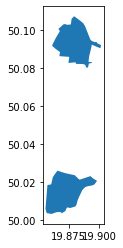

In [7]:
# read SUM areas: Bronowice and Skotniki
gdf_areas = gpd.read_file('data/sum_areas_B+S.shp')
gdf_areas = gdf_areas.rename(columns={"nazwa": "name"})
gdf_areas = gdf_areas.to_crs(4326)
gdf_areas.plot()

In [8]:
gdf_areas

,name,geometry
0,Bronowice Wielkie,"POLYGON ((19.87805 50.08284, 19.87469 50.08260..."
1,Skotniki,"POLYGON ((19.88842 50.01723, 19.88734 50.01662..."


In [9]:
# read ODMs and calculate probabilities for destibations
od = pd.read_excel('data/krk_ODM.xlsx', 'AM_peak_PuT', skiprows=[1, 2])
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
# filter OD zone number to match city zones and recalculate sum for origins
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od['sum'] = od.loc[:, 1:].sum(axis=1)
# calculate "probabilities" for each origin point
od_probs = pd.concat([od['zone_NO'], 
                    od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)], axis=1)

In [10]:
# read demographic of the city, clean data
df_demo = pd.read_csv('data/krk_demographic.csv', index_col=0)
df_demo = df_demo.rename(columns={"adr_pelny": "address", "ogolem": "total" })
# assign new x and y coordinates for addresses on "Starego dębu" street ADD distances to SKIM??!!
filter = ['STAREGO DĘBU' in i for i in df_demo['address']]
df_demo.loc[filter, 'x'], df_demo.loc[filter, 'y'] = 19.872702, 50.100578
# assign zone number to each address point
df_demo['zone_NO'] = df_demo.apply(lambda row: 
                                   fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
# remove the trips with nan zone
df_demo.dropna(subset='zone_NO', inplace=True, ignore_index=True)

<h5>Results for Bronowice area</h5>

In [11]:
# Bronowice area hub
b_hub_loc = (19.88192, 50.08179)
b_hub = ox.nearest_nodes(inData.G, b_hub_loc[0], b_hub_loc[1])

In [12]:
# Skotniki area hub
s_hub_loc = (19.88948, 50.01844)
s_hub = ox.nearest_nodes(inData.G, s_hub_loc[0], s_hub_loc[1])

In [13]:
# TODO: make function to run simulations
ASC = 2.58
N=1 # number of replications
dfres = pd.DataFrame() 

# run simulations
for repl in range(N):
    # Generate demand for SUM areas: 
    # reqs = {"Bronowice Wielkie": (O,D,T), "Skotniki": (O,D,T)}
    area_reqs = fncs.define_demand(gdf_areas, df_demo, gdf_centroid, od, od_probs)
    # change area to Skotniki
    bronowice_reqs = area_reqs["Bronowice Wielkie"]
    df = bronowice_reqs
    # skotniki_reqs = area_reqs['Skotniki']
    # df = skotniki_reqs
    
    # Utility for PT origin-destination
    df1 = df.copy()
    df1 = fncs.run_OTP(df1, OTP_API)
    u_PT_OD = fncs.PT_utility(df1, params)
    
    df = df.loc[u_PT_OD.index, :] # select requests with successful OD trips 
    df.reset_index(drop=True, inplace=True)

    reqs = df.copy()
    reqs['origin'] = reqs.apply(lambda row: ox.nearest_nodes(inData.G, row['origin_x'], row['origin_y']), axis=1)
    reqs['destination'] = b_hub   # change to s_hub
    reqs['dist'] = reqs.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    reqs['ttrav'] = reqs['dist'].apply(lambda request: request / params.avg_speed)
    reqs['u'] = reqs.apply(lambda request: request['ttrav'] * params.VoT + request['dist'] * params.price /1000, axis=1)
    
    df_SUM = df.copy()
    df_SUM.reset_index()
    df_SUM['hub'] = b_hub    # change to s_hub
    df_SUM['ttrav'] = reqs.ttrav
    df_SUM['tarr'] = pd.to_datetime(reqs.treq) + df_SUM.apply(lambda df_SUM: pd.Timedelta(df_SUM.ttrav, 's').floor('s'), axis=1)
    df_SUM['u'] = reqs.u

    # Utility for PT hub-destination
    df2 = df_SUM.rename(columns = {'treq': 'treq_origin'})
    df2['origin_x'] = b_hub_loc[0] # change to s_hub
    df2['origin_y'] = b_hub_loc[1] # change to s_hub
    df2['treq'] = pd.to_datetime(df_SUM.tarr) + pd.Timedelta(params.transfertime, unit='s') # treq for PT
    df2 = fncs.run_OTP(df2, OTP_API)
    u_PT_HD = fncs.PT_utility(df2, params)

    df_SUM['u_SUM_OD'] = df_SUM.u + u_PT_HD.u_PT + ASC
    df_SUM['p_SUM'] = df_SUM.apply(lambda df_SUM: math.exp(-df_SUM.u_SUM_OD), axis=1) / \
                         (df_SUM.apply(lambda df_SUM: math.exp(-df_SUM.u_SUM_OD), axis=1) +  \
                          u_PT_OD.apply(lambda u_PT_OD: math.exp(-u_PT_OD.u_PT), axis=1))
    df_res= pd.DataFrame([[u_PT_OD.waitingTime.mean(), u_PT_HD.waitingTime.mean(), u_PT_OD.u_PT.mean(),
                           u_PT_HD.u_PT.mean(), df_SUM.u_SUM_OD.mean(), df_SUM.p_SUM.mean()]], 
                           columns=['tw_PT_OD', 'tw_PT_HD', 'u_PT_OD', 'u_PT_HD', 'u_SUM_OD', 'p_SUM'])

    dfres = pd.concat([dfres, df_res], ignore_index=True)

In [15]:
# save results
# dfres.to_csv("results/bronowice_" + str(N) + ".csv")
# dfres.to_csv("results/skotniki_" + str(N) + ".csv")

<h5>Calculate ASC</h5>

In [16]:
def calc_E_Psum(ASC=0):
    df_SUM['u_SUM_OD'] = df_SUM.u + u_PT_HD.u_PT + ASC
    df_SUM['p_SUM'] = df_SUM.apply(lambda df_SUM: math.exp(-df_SUM.u_SUM_OD), axis=1) / \
                        (df_SUM.apply(lambda df_SUM: math.exp(-df_SUM.u_SUM_OD), axis=1) +  \
                        u_PT_OD.apply(lambda u_PT_OD: math.exp(-u_PT_OD.u_PT), axis=1))
    return df_SUM.p_SUM.mean()

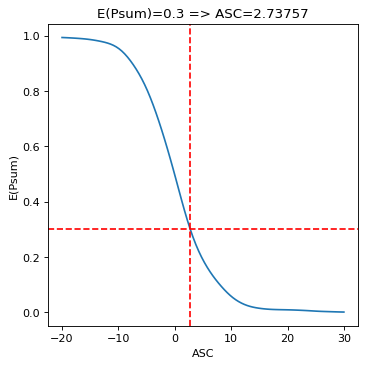

In [17]:
# Calculate ASC for the given E(Psum)
EPsum = 0.3
asc_opt = optimize.fsolve(lambda x: calc_E_Psum(x) - EPsum, 0)[0]
# Show graphics
ascs = np.linspace(-20, 30, 100)
plt.figure(figsize=(5, 5), dpi=80)
plt.plot(ascs, [calc_E_Psum(asc) for asc in ascs])
plt.title(f'E(Psum)={EPsum} => ASC={round(asc_opt, 5)}')
plt.xlabel('ASC')
plt.ylabel('E(Psum)')
plt.axhline(EPsum, color='red', linestyle='--')
plt.axvline(asc_opt, color='red', linestyle='--')
plt.show()

<h4>ExMAS for SUM areas</h4>

In [18]:
# Bronowice area
# hub = (19.88192, 50.08179)
fncs.run_ExMAS(bronowice_reqs, inData, params, b_hub_loc, degree=8)

04-06-24 23:45:52-INFO-Initializing pairwise trip shareability between 467 and 467 trips.
04-06-24 23:45:52-INFO-creating combinations
04-06-24 23:45:52-INFO-217622	 nR*(nR-1)
04-06-24 23:45:54-INFO-Reduction of feasible pairs by 98.45%
04-06-24 23:45:54-INFO-Degree 2 	Completed
04-06-24 23:45:54-INFO-trips to extend at degree 2 : 6578
04-06-24 23:46:05-INFO-At degree 2 feasible extensions found out of 8996 searched
04-06-24 23:46:05-INFO-Degree 3 	Completed
04-06-24 23:46:05-INFO-trips to extend at degree 3 : 8996
04-06-24 23:46:30-INFO-At degree 3 feasible extensions found out of 13785 searched
04-06-24 23:46:30-INFO-Degree 4 	Completed
04-06-24 23:46:30-INFO-trips to extend at degree 4 : 13785
04-06-24 23:47:07-INFO-At degree 4 feasible extensions found out of 10273 searched
04-06-24 23:47:07-INFO-Degree 5 	Completed
04-06-24 23:47:07-INFO-trips to extend at degree 5 : 10273
04-06-24 23:47:32-INFO-At degree 5 feasible extensions found out of 3020 searched
04-06-24 23:47:32-INFO-Degr

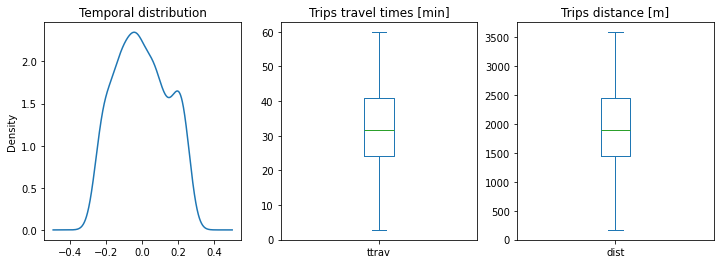

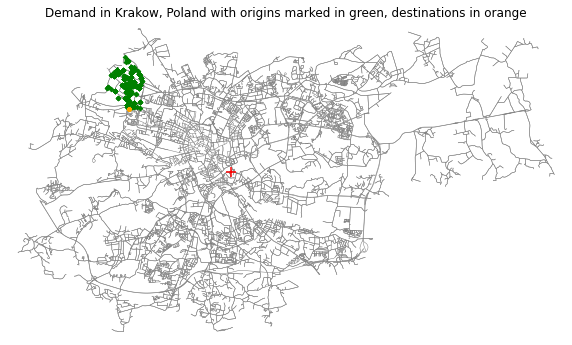

In [19]:
ExMAS.utils.plot_demand(inData, params)

In [21]:
# Skotniki area
skotniki_reqs = area_reqs['Skotniki']
# hub = (19.88948, 50.01844)
fncs.run_ExMAS(skotniki_reqs, inData, params, s_hub_loc, degree=8)

04-06-24 23:58:56-INFO-Initializing pairwise trip shareability between 173 and 173 trips.
04-06-24 23:58:56-INFO-creating combinations
04-06-24 23:58:56-INFO-29756	 nR*(nR-1)
04-06-24 23:58:56-INFO-Reduction of feasible pairs by 98.75%
04-06-24 23:58:56-INFO-Degree 2 	Completed
04-06-24 23:58:56-INFO-trips to extend at degree 2 : 786
04-06-24 23:58:57-INFO-At degree 2 feasible extensions found out of 213 searched
04-06-24 23:58:57-INFO-Degree 3 	Completed
04-06-24 23:58:57-INFO-trips to extend at degree 3 : 213
04-06-24 23:58:57-INFO-At degree 3 feasible extensions found out of 80 searched
04-06-24 23:58:57-INFO-Degree 4 	Completed
04-06-24 23:58:57-INFO-trips to extend at degree 4 : 80
04-06-24 23:58:57-INFO-At degree 4 feasible extensions found out of 2 searched
04-06-24 23:58:57-INFO-Degree 5 	Completed
04-06-24 23:58:57-INFO-trips to extend at degree 5 : 2
04-06-24 23:58:57-INFO-At degree 5 feasible extensions found out of 0 searched
04-06-24 23:58:57-INFO-Degree 6 	Completed
04-06

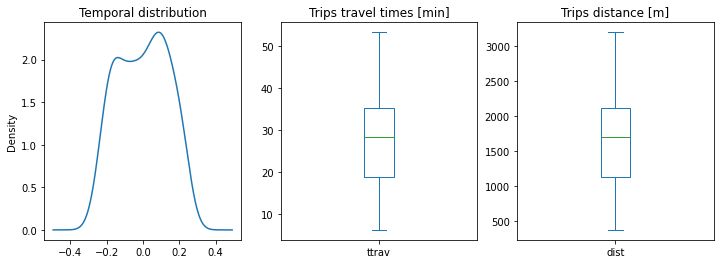

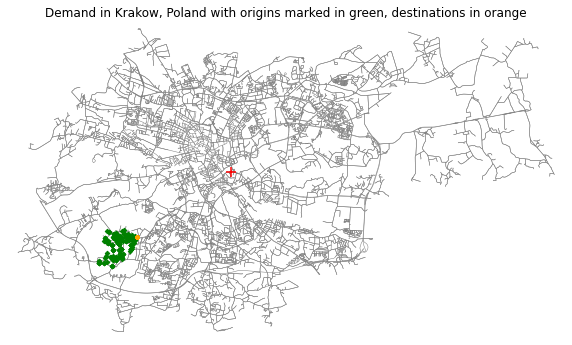

In [22]:
ExMAS.utils.plot_demand(inData, params)